In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset Generation with non-compatible outfits

In [ ]:
#Imports
import csv
import gzip
import itertools
import json
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
import torchvision
from PIL import Image
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
from torchvision import models
from sklearn import metrics

In [ ]:
class CategoryDataset(Dataset):
    def __init__(self,
                 root_dir="/content/drive/MyDrive/ML_Final_Project/data/images/",
                 data_file="/content/drive/MyDrive/ML_Final_Project/data/train_no_dup_with_category_3more_name.json",
                 data_dir="/content/drive/MyDrive/ML_Final_Project/data/",
                 transform=None,
                 use_mean_img=True,
                 neg_samples=True):
        self.root_dir = root_dir
        self.data_dir = data_dir
        self.transform = transform
        self.use_mean_img = use_mean_img
        self.data = json.load(open(os.path.join(data_dir, data_file)))
        self.data = [(k, v) for k, v in self.data.items()]
        self.neg_samples = neg_samples # if True, will randomly generate negative outfit samples

        self.vocabulary, self.word_to_idx = [], {}
        self.word_to_idx['UNK'] = len(self.word_to_idx)
        self.vocabulary.append('UNK')
        with open(os.path.join(self.data_dir, 'final_word_dict.txt')) as f:
            for line in f:
                name = line.strip().split()[0]
                if name not in self.word_to_idx:
                    self.word_to_idx[name] = len(self.word_to_idx)
                    self.vocabulary.append(name)


    def __getitem__(self, index):
        """It could return a positive suits or negative suits"""
        set_id, parts = self.data[index]
        if random.randint(0, 1) and self.neg_samples:
            #to_change = random.sample(list(parts.keys()), 3) # random choose 3 negative items
            to_change = list(parts.keys()) # random choose negative items
        else:
            to_change = []
        imgs = []
        labels = []
        names = []
        for part in ['upper', 'bottom', 'shoe', 'bag', 'accessory']:
            if part in to_change: # random choose a image from dataset with same category
                choice = self.data[index]
                while (choice[0] == set_id) or (part not in choice[1].keys()):
                    choice = random.choice(self.data)
                img_path = os.path.join(self.root_dir, str(choice[0]), str(choice[1][part]['index'])+'.jpg')
                names.append(torch.LongTensor(self.str_to_idx(choice[1][part]['name'])))
                labels.append('{}_{}'.format(choice[0], choice[1][part]['index']))
            elif part in parts.keys():
                img_path = os.path.join(self.root_dir, str(set_id), str(parts[part]['index'])+'.jpg')
                names.append(torch.LongTensor(self.str_to_idx(parts[part]['name'])))
                labels.append('{}_{}'.format(set_id, parts[part]['index']))
            elif self.use_mean_img:
                img_path = os.path.join(self.data_dir, part+'.png')
                names.append(torch.LongTensor([])) # mean_img embedding
                labels.append('{}_{}'.format(part, 'mean'))
            else:
                continue
            img = Image.open(img_path).convert('RGB')
            img = self.transform(img)
            imgs.append(img)
        input_images = torch.stack(imgs)
        is_compat = (len(to_change)==0)

        offsets = list(itertools.accumulate([0] + [len(n) for n in names[:-1]]))
        offsets = torch.LongTensor(offsets)
        return input_images, names, offsets, set_id, labels, is_compat

    def __len__(self):
        return len(self.data)

    def str_to_idx(self, name):
        return [self.word_to_idx[w] if w in self.word_to_idx else self.word_to_idx['UNK']
            for w in name.split()]

def collate_fn(data):
    """Need custom a collate_fn"""
    data.sort(key=lambda x:x[0].shape[0], reverse=True)
    images,  names, offsets, set_ids, labels, is_compat = zip(*data)
    lengths = [i.shape[0] for i in images]
    is_compat = torch.LongTensor(is_compat)
    names = sum(names, [])
    offsets = list(offsets)
    images = torch.stack(images)
    return (
        lengths,
        images,
        names,
        offsets,
        set_ids,
        labels,
        is_compat
    )

# Helper Functions

In [ ]:
import logging

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class BestSaver(object):
    def __init__(self, comment=None):
        # Get current executing script name
        import __main__, os
        save_path = "./model"

        if comment is not None and str(comment):
            save_path = save_path + "_" + str(comment)

        save_path = save_path + ".pth"

        self.save_path = save_path
        self.best = float('-inf')

    def save(self, metric, data):
        if metric > self.best:
            self.best = metric
            torch.save(data, self.save_path)
            logging.info("Saved best model to {}".format(self.save_path))


def config_logging(comment=None):
    """Configure logging for training log. The format is
        `log_{log_fname}_{comment}.log`
    .g. for `train.py`, the log_fname is `log_train.log`.
    Use `logging.info(...)` to record running log.
    Args:
        comment (any): Append comment for log_fname
    """

    # Get current executing script name
    import __main__, os
    log_fname = "./logger"

    if comment is not None and str(comment):
        log_fname = log_fname + "_" + str(comment)

    log_fname = log_fname + ".log"
    log_format = "%(asctime)s [%(levelname)-5.5s] %(message)s"

    logging.basicConfig(
        level=logging.INFO,
        format=log_format,
        handlers=[logging.FileHandler(log_fname), logging.StreamHandler()]
    )

def prepare_dataloaders(root_dir="/content/drive/MyDrive/ML_Final_Project/data/images/", data_dir="/content/drive/MyDrive/ML_Final_Project/data/", batch_size=16, img_size=224, use_mean_img=True, neg_samples=True, num_workers=1, collate_fn=collate_fn):
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((img_size, img_size)),
            torchvision.transforms.ToTensor(),
        ]
    )
    train_dataset = CategoryDataset(
        root_dir=root_dir,
        data_dir=data_dir,
        transform=transform,
        use_mean_img=use_mean_img,
        data_file="/content/drive/MyDrive/ML_Final_Project/data/train_no_dup_with_category_3more_name.json",
    )
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn
    )
    val_dataset = CategoryDataset(
        root_dir=root_dir,
        data_dir=data_dir,
        transform=transform,
        use_mean_img=use_mean_img,
        data_file="/content/drive/MyDrive/ML_Final_Project/data/valid_no_dup_with_category_3more_name.json",
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn
    )
    test_dataset = CategoryDataset(
        root_dir=root_dir,
        data_dir=data_dir,
        transform=transform,
        use_mean_img=use_mean_img,
        data_file="/content/drive/MyDrive/ML_Final_Project/data/test_no_dup_with_category_3more_name.json",
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn
    )
    return train_dataset, train_loader, val_dataset, val_loader, test_dataset, test_loader

# Resnet for Feature Extraction

In [ ]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']

In [ ]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, need_rep=False):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.need_rep = need_rep

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        rep_l1 = x
        x = self.layer2(x)
        rep_l2 = x
        x = self.layer3(x)
        rep_l3 = x
        x = self.layer4(x)
        rep_l4 = x

        x = self.avgpool(x)
        rep = x.view(x.size(0), -1)
        x = self.fc(rep)

        if self.need_rep:
            # return x, rep
            return x, rep_l1, rep_l2, rep_l3, rep_l4, rep
        else:
            return x

def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

# Compatible Model

In [ ]:
import itertools

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torchvision.models as models

In [ ]:
class CompatModel(nn.Module):
    def __init__(
            self,
            embed_size=1000,
            need_rep=False,
            vocabulary=None,
            vse_off=False,
            pe_off=False,
            mlp_layers=2,
            conv_feats="1234",
        ):
        super(CompatModel, self).__init__()
        self.vse_off = vse_off
        self.pe_off = pe_off
        self.mlp_layers = mlp_layers
        self.conv_feats = conv_feats

        cnn = resnet50(pretrained=True, need_rep=need_rep)
        cnn.fc = nn.Linear(cnn.fc.in_features, embed_size)
        self.cnn = cnn
        self.need_rep = need_rep
        self.num_rela = 15 * len(conv_feats)
        self.bn = nn.BatchNorm1d(self.num_rela)  # 5x5 relationship matrix have 25 elements

        # Define predictor part
        if self.mlp_layers > 0:
            predictor = []
            for _ in range(self.mlp_layers-1):
                linear = nn.Linear(self.num_rela, self.num_rela)
                nn.init.xavier_uniform_(linear.weight)
                nn.init.constant_(linear.bias, 0)
                predictor.append(linear)
                predictor.append(nn.ReLU())
            linear = nn.Linear(self.num_rela, 1)
            nn.init.xavier_uniform_(linear.weight)
            nn.init.constant_(linear.bias, 0)
            predictor.append(linear)
            self.predictor = nn.Sequential(*predictor)
        self.sigmoid = nn.Sigmoid()

        nn.init.xavier_uniform_(cnn.fc.weight)
        nn.init.constant_(cnn.fc.bias, 0)

        # Type specified masks
        # l1, l2, l3 is the masks for feature maps for the beginning layers
        # not suffix one is for the last layer
        self.masks = nn.Embedding(15, embed_size)
        self.masks.weight.data.normal_(0.9, 0.7)
        self.masks_l1 = nn.Embedding(15, 256)
        self.masks_l1.weight.data.normal_(0.9, 0.7)
        self.masks_l2 = nn.Embedding(15, 512)
        self.masks_l2.weight.data.normal_(0.9, 0.7)
        self.masks_l3 = nn.Embedding(15, 1024)
        self.masks_l3.weight.data.normal_(0.9, 0.7)

        # Semantic embedding model
        self.sem_embedding = nn.Embedding(vocabulary, 1000)
        # Visual embedding model
        self.image_embedding = nn.Linear(2048, 1000)

        # Global average pooling layer
        self.ada_avgpool2d = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, images, names):
        if self.need_rep:
            out, features, tmasks, rep = self._compute_score(images)
        else:
            out, features, tmasks = self._compute_score(images)

        if self.vse_off:
            vse_loss = torch.tensor(0.)
        else:
            vse_loss = self._compute_vse_loss(names, rep)
        if self.pe_off:
            tmasks_loss, features_loss = torch.tensor(0.), torch.tensor(0.)
        else:
            tmasks_loss, features_loss = self._compute_type_repr_loss(tmasks, features)

        return out, vse_loss, tmasks_loss, features_loss

    def _compute_vse_loss(self, names, rep):
        # Normalized Semantic Embedding
        padded_names = rnn_utils.pad_sequence(names, batch_first=True).to(rep.device)
        mask = torch.gt(padded_names, 0)
        cap_mask = torch.ge(mask.sum(dim=1), 2)
        semb = self.sem_embedding(padded_names)
        semb = semb * (mask.unsqueeze(dim=2)).float()
        word_lengths = mask.sum(dim=1)
        word_lengths = torch.where(
            word_lengths == 0,
            (torch.ones(semb.shape[0]).float() * 0.1).to(rep.device),
            word_lengths.float(),
        )
        semb = semb.sum(dim=1) / word_lengths.unsqueeze(dim=1)
        semb = F.normalize(semb, dim=1)

        # Normalized Visual Embedding
        vemb = F.normalize(self.image_embedding(rep), dim=1)

        # VSE Loss
        semb = torch.masked_select(semb, cap_mask.unsqueeze(dim=1))
        vemb = torch.masked_select(vemb, cap_mask.unsqueeze(dim=1))
        semb = semb.reshape([-1, 1000])
        vemb = vemb.reshape([-1, 1000])
        scores = torch.matmul(semb, vemb.transpose(0, 1))
        diagnoal = scores.diag().unsqueeze(dim=1)
        cost_s = torch.clamp(0.2 - diagnoal + scores, min=0, max=1e6)  # 0.2 is margin
        cost_im = torch.clamp(0.2 - diagnoal.transpose(0, 1) + scores, min=0, max=1e6)
        cost_s = cost_s - torch.diag(cost_s.diag())
        cost_im = cost_im - torch.diag(cost_im.diag())
        vse_loss = cost_s.sum() + cost_im.sum()
        vse_loss = vse_loss / (semb.shape[0] ** 2)

        return vse_loss

    def _compute_type_repr_loss(self, tmasks, features):
        # Type embedding loss
        tmasks_loss = tmasks.norm(1) / len(tmasks)
        features_loss = features.norm(2) / np.sqrt(
            (features.shape[0] * features.shape[1])
        )
        return tmasks_loss, features_loss

    def _compute_score(self, images, activate=True):
        """Extract feature vectors from input images.
        Return:
            out: the compatibility score
            features: the visual embedding of the images, we use 1000-d in all experiments
            masks: the mask for type-specified embedding
            rep: the represtions of the second last year, which is 2048-d for resnet-50 backend
        """
        batch_size, item_num, _, _, img_size = images.shape
        images = torch.reshape(images, (-1, 3, img_size, img_size))
        if self.need_rep:
            features, *rep = self.cnn(images)
            rep_l1, rep_l2, rep_l3, rep_l4, rep = rep
        else:
            features = self.cnn(images)

        relations = []
        features = features.reshape(batch_size, item_num, -1)  # (32, 5, 1000)
        masks = F.relu(self.masks.weight)
        # Comparison matrix
        if "4" in self.conv_feats:
            for mi, (i, j) in enumerate(itertools.combinations_with_replacement([0,1,2,3,4], 2)):
                if self.pe_off:
                    left = F.normalize(features[:, i:i+1, :], dim=-1) # (32, 1, 1000)
                    right = F.normalize(features[:, j:j+1, :], dim=-1)
                else:
                    left = F.normalize(masks[mi] * features[:, i:i+1, :], dim=-1) # (32, 1, 1000)
                    right = F.normalize(masks[mi] * features[:, j:j+1, :], dim=-1)
                rela = torch.matmul(left, right.transpose(1, 2)).squeeze() # (32)
                relations.append(rela)

        # Comparision at Multi-Layered representations
        rep_list = []
        masks_list = []
        if "1" in self.conv_feats:
            rep_list.append(rep_l1); masks_list.append(self.masks_l1)
        if "2" in self.conv_feats:
            rep_list.append(rep_l2); masks_list.append(self.masks_l2)
        if "3" in self.conv_feats:
            rep_list.append(rep_l3); masks_list.append(self.masks_l3)
        for rep_li, masks_li in zip(rep_list, masks_list):
            rep_li = self.ada_avgpool2d(rep_li).squeeze().reshape(batch_size, item_num, -1)
            masks_li = F.relu(masks_li.weight)
            # Enumerate all pairwise combination among the outfit then compare their features
            for mi, (i, j) in enumerate(itertools.combinations_with_replacement([0,1,2,3,4], 2)):
                if self.pe_off:
                    left = F.normalize(masks_li[mi] * rep_li[:, i:i+1, :], dim=-1) # (32, 1, 1000)
                    right = F.normalize(masks_li[mi] * rep_li[:, j:j+1, :], dim=-1)
                else:
                    left = F.normalize(masks_li[mi] * rep_li[:, i:i+1, :], dim=-1) # (32, 1, 1000)
                    right = F.normalize(masks_li[mi] * rep_li[:, j:j+1, :], dim=-1)
                rela = torch.matmul(left, right.transpose(1, 2)).squeeze() # (32)
                relations.append(rela)

        if batch_size == 1: # Inference during evaluation, which input one sample
            relations = torch.stack(relations).unsqueeze(0)
        else:
            relations = torch.stack(relations, dim=1) # (32 ,15*4)
        relations = self.bn(relations)

        # Predictor
        if self.mlp_layers == 0:
            out = relations.mean(dim=-1, keepdim=True)
        else:
            out = self.predictor(relations)

        if activate:
            out = self.sigmoid(out)
        if self.need_rep:
            return out, features, masks, rep
        else:
            return out, features, masks

# Training Compatible Model

In [ ]:
import logging
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn import metrics
from torch.optim import lr_scheduler
from torchvision import models
import matplotlib.pyplot as plt
import pandas as pd
# from sklearn.metrics import roc_curve

In [ ]:
def plot_roc_and_auc(y_test, y_preds):
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds)
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'y--')
  plt.plot(fpr, tpr, marker='.')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.show()

  i = np.arange(len(tpr))
  roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
  ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
  print("Ideal threshold is: ", ideal_roc_thresh['thresholds'])

  auc_value = metrics.auc(fpr, tpr)
  print("Area under curve, AUC = ", auc_value)

  return auc_value

In [ ]:
comment = ""
vse_off = "store_true"
pe_off = "store_true"
mlp_layers = 2
conv_feats = "1234"

config_logging(comment)

# Dataloader
train_dataset, train_loader, val_dataset, val_loader, test_dataset, test_loader = (
    prepare_dataloaders(batch_size=16)
)

# Device
device = torch.device("cuda:0")

# Model
model = CompatModel(embed_size=1000, need_rep=True, vocabulary=len(train_dataset.vocabulary),
                    vse_off=vse_off, pe_off=pe_off, mlp_layers=mlp_layers, conv_feats=conv_feats)

# Train process
def train(model, device, train_loader, val_loader, comment):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    saver = BestSaver(comment)
    epochs = 10
    for epoch in range(1, epochs + 1):
        print("Train Phase, Epoch: {}".format(epoch))
        scheduler.step()
        total_losses = AverageMeter()
        clf_losses = AverageMeter()
        vse_losses = AverageMeter()
        # Train phase
        model.train()
        for batch_num, batch in enumerate(train_loader, 1):
            lengths, images, names, offsets, set_ids, labels, is_compat = batch
            images = images.to(device)

            # Forward
            output, vse_loss, tmasks_loss, features_loss = model(images, names)

            # BCE Loss
            target = is_compat.float().to(device)
            output = output.squeeze(dim=1)
            clf_loss = criterion(output, target)

            # Sum all losses up
            features_loss = 5e-3 * features_loss
            tmasks_loss = 5e-4 * tmasks_loss
            total_loss = clf_loss + vse_loss + features_loss + tmasks_loss

            # Update Recoder
            total_losses.update(total_loss.item(), images.shape[0])
            clf_losses.update(clf_loss.item(), images.shape[0])
            vse_losses.update(vse_loss.item(), images.shape[0])

            # Backpropagation
            model.zero_grad()
            total_loss.backward()
            optimizer.step()
            if batch_num % 10 == 0:
                print(
                    "[{}/{}] #{} clf_loss: {:.4f}, vse_loss: {:.4f}, features_loss: {:.4f}, tmasks_loss: {:.4f}, total_loss:{:.4f}".format(
                        epoch, epochs, batch_num, clf_losses.val, vse_losses.val, features_loss, tmasks_loss, total_losses.val
                    )
                )
        print("Train Loss (clf_loss): {:.4f}".format(clf_losses.avg))

        # Valid Phase
        print("Valid Phase, Epoch: {}".format(epoch))
        model.eval()
        clf_losses = AverageMeter()
        outputs = []
        targets = []
        for batch_num, batch in enumerate(val_loader, 1):
            lengths, images, names, offsets, set_ids, labels, is_compat = batch
            images = images.to(device)
            target = is_compat.float().to(device)
            with torch.no_grad():
                output, _, _, _ = model._compute_score(images)
                output = output.squeeze(dim=1)
                clf_loss = criterion(output, target)
            clf_losses.update(clf_loss.item(), images.shape[0])
            outputs.append(output)
            targets.append(target)
        print("Valid Loss (clf_loss): {:.4f}".format(clf_losses.avg))
        outputs = torch.cat(outputs).cpu().data.numpy()
        targets = torch.cat(targets).cpu().data.numpy()
        auc = metrics.roc_auc_score(targets, outputs)
        # plot_roc_and_auc(outputs, targets)
        print("AUC: {:.4f}".format(auc))
        predicts = np.where(outputs > 0.5, 1, 0)
        accuracy = metrics.accuracy_score(predicts, targets)
        print("Accuracy@0.5: {:.4f}".format(accuracy))
        positive_loss = -np.log(outputs[targets==1]).mean()
        print("Positive loss: {:.4f}".format(positive_loss))
        positive_acc = sum(outputs[targets==1]>0.5) / len(outputs)
        logging.info("Positive accuracy: {:.4f}".format(positive_acc))
        print("Positive accuracy: {:.4f}".format(positive_acc))

        # Save best model
        saver.save(auc, model.state_dict())

In [ ]:
train(model, device, train_loader, val_loader, comment)

Train Phase, Epoch: 1


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train Loss (clf_loss): 1.2349
Valid Phase, Epoch: 1
Valid Loss (clf_loss): 0.9033
AUC: 0.2667
Accuracy@0.5: 0.6250
Positive loss: 0.1229
Positive accuracy: 0.6250
Train Phase, Epoch: 2
Train Loss (clf_loss): 1.1679
Valid Phase, Epoch: 2
Valid Loss (clf_loss): 1.5801
AUC: 0.3333
Accuracy@0.5: 0.2500
Positive loss: 0.1420
Positive accuracy: 0.2500
Train Phase, Epoch: 3
Train Loss (clf_loss): 1.2196
Valid Phase, Epoch: 3
Valid Loss (clf_loss): 0.5943
AUC: 0.5833
Accuracy@0.5: 0.7500
Positive loss: 0.1591
Positive accuracy: 0.7500
Train Phase, Epoch: 4
Train Loss (clf_loss): 0.8913
Valid Phase, Epoch: 4
Valid Loss (clf_loss): 0.5857
AUC: 0.3333
Accuracy@0.5: 0.7500
Positive loss: 0.1927
Positive accuracy: 0.7500
Train Phase, Epoch: 5
Train Loss (clf_loss): 0.7051
Valid Phase, Epoch: 5
Valid Loss (clf_loss): 0.7569
AUC: 0.2667
Accuracy@0.5: 0.6250
Positive loss: 0.2221
Positive accuracy: 0.6250
Train Phase, Epoch: 6
Train Loss (clf_loss): 0.7802
Valid Phase, Epoch: 6
Valid Loss (clf_loss): 

# Evaluate.py

In [ ]:
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn import metrics
from torchvision import models

In [ ]:
criterion = nn.BCELoss()

# Compatibility AUC test
model.eval()
total_loss = 0
outputs = []
targets = []
for batch_num, batch in enumerate(test_loader, 1):
    print("\r#{}/{}".format(batch_num, len(test_loader)), end="", flush=True)
    lengths, images, names, offsets, set_ids, labels, is_compat = batch
    images = images.to(device)
    target = is_compat.float().to(device)
    with torch.no_grad():
        output, _, _, _ = model._compute_score(images)
        output = output.squeeze(dim=1)
        loss = criterion(output, target)
    total_loss += loss.item()
    outputs.append(output)
    targets.append(target)
print()
print("Test Loss: {:.4f}".format(total_loss / batch_num))
outputs = torch.cat(outputs).cpu().data.numpy()
targets = torch.cat(targets).cpu().data.numpy()
print("AUC: {:.4f}".format(metrics.roc_auc_score(targets, outputs)))

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#1/1
Test Loss: 0.6717
AUC: 0.4667


# Diagnosis.py

In [ ]:
import itertools
import os
import warnings

import cv2
import matplotlib; matplotlib.use('agg')
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
from sklearn import metrics
from IPython.display import display

In [ ]:
def loadimg_from_id(ID, root_dir=test_dataset.root_dir):
    """load image from pre-defined id.

    Args:
        ID: List of ids of 5 items.

    Return:
        imgs: torch.tensor of shape (1, 5, 3, 224, 224)
    """
    imgs = []

    count = 1
    for id in ID:
        if 'mean' in id:
            img_path = os.path.join(test_dataset.data_dir, id.split('_')[0]) + '.png'
        else:
            img_path = os.path.join(root_dir, *id.split('_')) + '.jpg'

        img = Image.open(img_path).convert('RGB')
        print("------------------------ Layer " + str(count) + "------------------------")
        display(img)
        print("-------------------------------------------------")
        img = test_dataset.transform(img)
        imgs.append(img)
        count += 1
    imgs = torch.stack(imgs)
    imgs = imgs.unsqueeze(0)
    return imgs

def defect_detect(img, model, normalize=True):
    """ Compute the gradients of each element in the comparison matrices to
    approximate the problem of each input.

    Args:
        img: images of shape (N, 3, 224, 224).
        model: the model to compute the compatibility score.
        normalize: whether to normalize the relation results.

    Return:
        relation: gradients on comparison matrix.
        out: prediction score.
    """
    # Register hook for comparison matrix
    relation = None
    def func_r(module, grad_in, grad_out):
        nonlocal relation
        relation = grad_in[1].detach()

    for name, module in model.named_modules():
        if name == 'predictor.0':
            module.register_backward_hook(func_r)

    # Forward
    out, *_ = model._compute_score(img)
    one_hot = torch.FloatTensor([[-1]]).to(device)

    # Backward
    model.zero_grad()
    out.backward(gradient=one_hot, retain_graph=True)

    if normalize:
        relation = relation / (relation.max() - relation.min())
    relation += 1e-3
    return relation, out.item()

def vec2mat(relation, select):
    """ Convert relation vector to 4 matrix, which is corresponding to 4 layers
    in the backend CNN.

    Args:
        relation: (np.array | torch.tensor) of shpae (60,)
        select: List of select item indices, e.g. (0, 2, 3) means select 3 items
            in total 5 items in the outfit.

    Return:
        mats: List of matrix
    """
    mats = []
    for idx in range(4):
        mat = torch.zeros(5, 5)
        mat[np.triu_indices(5)] = relation[15*idx:15*(idx+1)]
        mat += torch.triu(mat, 1).transpose(0, 1)
        mat = mat[select, :]
        mat = mat[:, select]
        mats.append(mat)
    return mats

def show_rela_diagnosis(relation, select, cmap=plt.cm.Blues):
    """ Visualize diagnosis on relationships of 4 scales

    Args:
        relation: (np.array | torch.tensor) of shpae (60,)
        select: List of select item indices
    """
    mats = vec2mat(relation , select)

    fig = plt.figure(figsize=(20, 5))
    all_names = {0:'Top', 1:'Bottom', 2:'Shoe', 3:'Bag', 4:'Accssory'}
    node_names = {i:all_names[s] for i, s in enumerate(select)}

    edge_vmax = max(m.max() for m in mats)
    edge_vmin = min(m.min() for m in mats)

    container = []
    for idx in range(4):
        A = mats[idx]
        if isinstance(A, torch.Tensor):
            A = A.cpu().data.numpy()

        A = np.triu(A, k=1)
        A = np.round(A, decimals=2)
        container.append(A)
    container = np.stack(container)
    sorted_vedge = sorted(container.ravel(), reverse=True)

    for idx in range(4):
        plt.subplot(1, 4, idx+1)
        plt.title("Layer {}".format(idx+1), fontsize=28)
        A = mats[idx]
        if isinstance(A, torch.Tensor):
            A = A.cpu().data.numpy()

        A = np.triu(A, k=1)
        A = np.round(A, decimals=2)
        indices = np.triu_indices(A.shape[0], k=1)
        weights = A[indices[0], indices[1]]
        # Generate graph
        G = nx.Graph()
        for i, j, weight in zip(*indices, weights):
            G.add_edge(node_names[i], node_names[j], weight=weight)

        elarge, esmall, filtered_weights = [], [], []
        for e in G.edges(data=True):
            if e[2]['weight'] in sorted_vedge[:3]:
                elarge.append((e[0], e[1]))
            else:
                esmall.append((e[0], e[1]))
                filtered_weights.append(e[2]['weight'])
        pos=nx.circular_layout(G) # positions for all nodes

        # nodes
        nx.draw_networkx_nodes(G, pos, nodelist=[n for n in G.nodes()], node_size=1600, node_color='#A0CBE2')

        # edges
        nx.draw_networkx_edges(G,pos,edgelist=esmall, width=6, alpha=0.5, edge_color=filtered_weights, edge_cmap=cmap,
                               edge_vmax=edge_vmax, edge_vmin=edge_vmin)
        nx.draw_networkx_edges(G,pos,edgelist=elarge, width=6, alpha=0.5, edge_color='red', style='dashed')

        # labels
        labels = nx.get_edge_attributes(G,'weight')
        nx.draw_networkx_labels(G,pos, font_size=18, font_family='Times New Roman')
        if len(select) == 4:
            nx.draw_networkx_edge_labels(G, pos, font_size=18, font_family='Times New Roman', edge_labels=labels, label_pos=0.33)
        else:
            nx.draw_networkx_edge_labels(G, pos, font_size=18, font_family='Times New Roman', edge_labels=labels)

        plt.axis('off')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    plt.tight_layout()
    # plt.show()
    plt.savefig("rela_diagnosis.pdf")
    print("Save diagnosis result to rela_diagnosis.pdf")

def item_diagnosis(relation, select):
    """ Output the most incompatible item in the outfit

    Return:
        result (list): Diagnosis value of each item
        order (list): The indices of items ordered by its importance
    """
    mats = vec2mat(relation, select)
    for m in mats:
        mask = torch.eye(*m.shape).byte()
        m.masked_fill_(mask, 0)
    result = torch.cat(mats).sum(dim=0)
    order = [i for i, j in sorted(enumerate(result), key=lambda x:x[1], reverse=True)]
    return result, order

------------------------ Layer 1------------------------


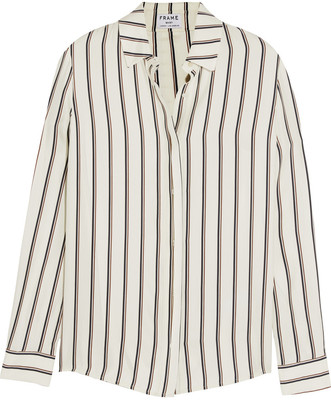

-------------------------------------------------
------------------------ Layer 2------------------------


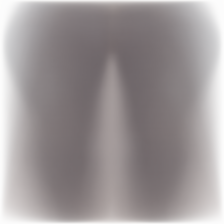

-------------------------------------------------
------------------------ Layer 3------------------------


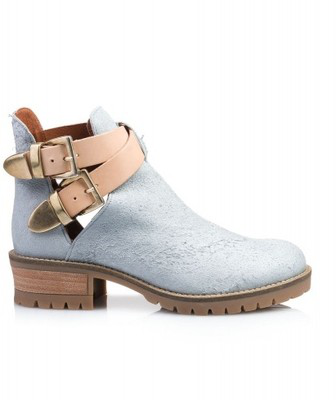

-------------------------------------------------
------------------------ Layer 4------------------------


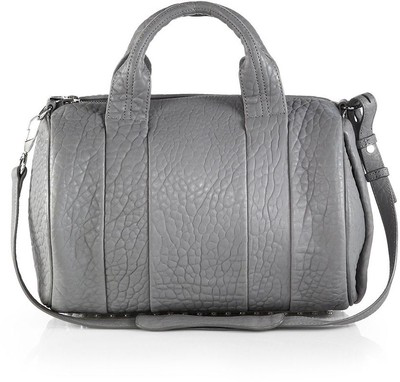

-------------------------------------------------
------------------------ Layer 5------------------------


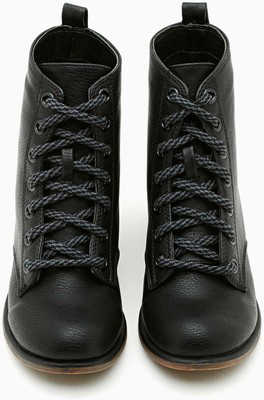

-------------------------------------------------
Step 1: show images in an outfit...
Save outfit to outfit.pdf

Step 2: show diagnosis results...
Save diagnosis result to rela_diagnosis.pdf
Predicted Score: 0.6684
Problem value of each item: tensor([-0.7342, -0.2883,  0.3770, -1.1927])
Order: [2, 1, 0, 3]


In [ ]:
ID = ['178118160_1', 'bottom_mean', '141530108_4', '111355382_5', '149659872_4']

print("Step 1: show images in an outfit...")
x = loadimg_from_id(ID).to(device)
# kick out the mean images for padding the sequence when making visualization
select = [i for i, l in enumerate(ID) if 'mean' not in l]

print("\nStep 2: show diagnosis results...")
relation, out = defect_detect(x, model)
relation = relation.squeeze().cpu().data
result, order = item_diagnosis(relation, select)
print("Predicted Score: {:.4f}\nProblem value of each item: {}\nOrder: {}".format(out, result, order))
print("="*80)